# **Exploratory Data Analysis with BlueBikes Data**
Written by Taiyo Nakai, November 2023

## I: Summary of findings
In December 2022,
- 83% of BlueBikes trips were made by subscribers.
- More than half of trips were under 10 minutes.
- The five most used BlueBikes stations in December 2022 were in Cambridge.
- The ridership and distance to the nearest T stop of a BlueBikes station do not correlate much
   - However, the most used BlueBikes stations are relatively close to T stops. This may be because both tend to be located at popular destinations like universities or other employment centers.

## II: Importing libraries

In [1]:
#Common libraries and packages for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Other libraries for EDA
import datetime
import calendar
#Libraries for geographic data
import folium
import geopandas as gpd
import requests
from geopy.distance import geodesic
import osmnx
import taxicab
#Library for stylizing maps from geographic data
import branca
import copy

## III: Loading data

In [2]:
#Reading BlueBikes data from December 2022
df = pd.read_csv(r"C:\Users\taiyo\OneDrive\Desktop\personal_projects\pp1BlueBikes\202212-bluebikes-tripdata.zip")

In [3]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,180,2022-12-01 00:02:44.9630,2022-12-01 00:05:45.2260,115,Porter Square Station,42.387995,-71.119084,99,Wilson Square,42.385676,-71.114121,8245,Subscriber,02143
1,295,2022-12-01 00:03:11.3990,2022-12-01 00:08:06.9320,32,Landmark Center - Brookline Ave at Park Dr,42.343691,-71.102353,160,Wentworth Institute of Technology - Huntington...,42.337586,-71.096271,6849,Subscriber,01886
2,737,2022-12-01 00:03:51.2520,2022-12-01 00:16:09.2200,200,Washington St at Melnea Cass Blvd,42.332817,-71.081198,36,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,2014,Subscriber,02120
3,887,2022-12-01 00:04:26.0750,2022-12-01 00:19:14.0430,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,7385,Subscriber,02143
4,307,2022-12-01 00:04:34.5180,2022-12-01 00:09:41.6680,515,955 Mass Ave,42.368952,-71.109988,89,Harvard Law School at Mass Ave / Jarvis St,42.379011,-71.119945,2798,Subscriber,02138


## IV: Exploring the data

I will first see how the quantitative variables are distributed.

In [4]:
df.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid
count,1.429120e+05,142912.000000,142912.000000,142912.000000,142912.000000,142912.000000,142912.000000,142912.000000
mean,1.286880e+03,205.289339,42.359593,-71.091651,204.233465,42.359436,-71.091052,5818.299898
std,2.428924e+04,172.959521,0.017877,0.026338,173.050970,0.017742,0.026306,1998.698141
min,6.100000e+01,1.000000,42.255600,-71.247759,1.000000,42.255600,-71.247759,2007.000000
25%,3.780000e+02,67.000000,42.348810,-71.107669,67.000000,42.348949,-71.106500,4083.000000
50%,6.010000e+02,141.000000,42.360542,-71.093198,139.000000,42.360274,-71.091690,6007.000000
75%,9.790000e+02,364.000000,42.368952,-71.074041,364.000000,42.368605,-71.073292,7719.000000
max,2.598790e+06,591.000000,42.529900,-70.880691,591.000000,42.529900,-70.880691,8656.000000


`tripduration` seems to be skewed; the mean is significantly greater than the median (1286 vs. 601).

In [5]:
df.isnull().sum()

tripduration                  0
starttime                     0
stoptime                      0
start station id              0
start station name            0
start station latitude        0
start station longitude       0
end station id                0
end station name              0
end station latitude          0
end station longitude         0
bikeid                        0
usertype                      0
postal code                8950
dtype: int64

Thankfully, this dataset has almost no missing data. By not using `postal code` in this project in lieu of the complete coordinate data (latitude and longitude for start and end stations), I will continue without data cleaning for the moment.

## V: Visualizing the data on graphs

I will keep `df` as a master dataframe, and will work on a (deep) copy, `df1`.

In [6]:
df1 = df.copy()
#Converting from seconds to minutes
df1['tripduration'] = df1['tripduration'].div(60)

### Part I: How long are BlueBikes rides?

We see below that most BlueBikes riders are subscribers (either Monthly or Annual).

In [7]:
print(f"In December 2022, {len(df1[(df1['usertype'] == 'Subscriber')]) / len(df1) * 100}% of trips were made by subscribers.")

In December 2022, 83.27572212270488% of trips were made by subscribers.


We also see that less than 1% of subscribers exceed their 45-minute cap (after which a "$2.50 per 30 minutes" fee incurs).

In [8]:
#Subscribers exceeding 45 minutes out of all subscribers
print(f"In December 2022, {len(df1[(df1['usertype'] == 'Subscriber') & (df1['tripduration'] > 45)]) / len(df1) * 100}% of subscriber trips exceeded 45 minutes.")

In December 2022, 0.694833184057322% of subscriber trips exceeded 45 minutes.


Since these seem like good cutoffs for looking at commuting patterns, I will look at **rides by subscribers under 45 minutes** in this project.

In [9]:
df1 = df1[(df1['usertype'] == 'Subscriber') & (df1['tripduration'] < 45)]
print(f"{len(df1) / len(df) * 100}% of the original data will be looked at in this project.")

82.58018920734438% of the original data will be looked at in this project.


Let us see how these trips are distributed via a histogram.

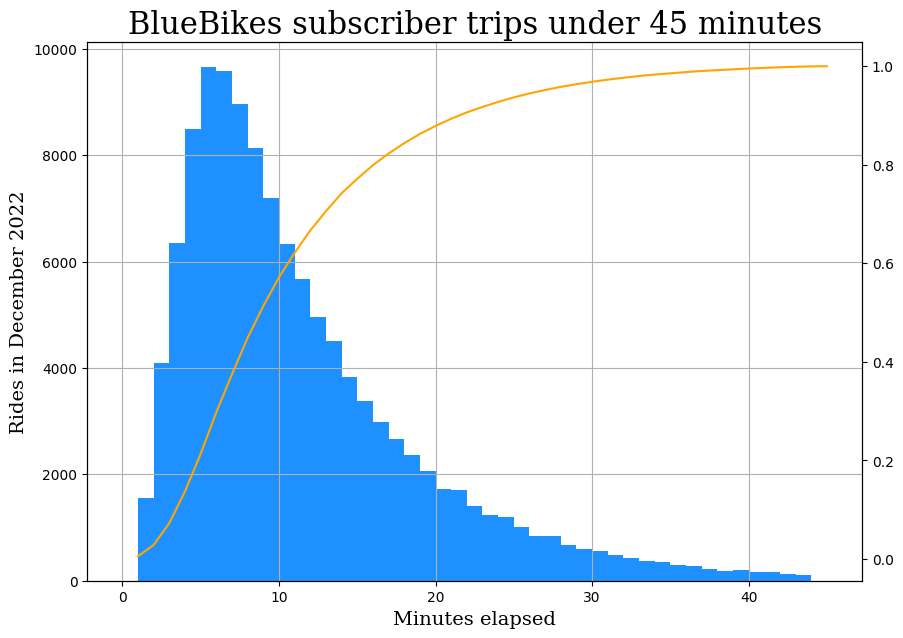

In [10]:
#A histogram of all trips under 45 minutes
fig, ax = plt.subplots(figsize = (10, 7))
ax.hist(df1['tripduration'], bins = np.arange(0, 45, 1), color='dodgerblue')

#Plotting a line representing the cumulative sum
rounded_durations = np.round(df1['tripduration'])
cdf = np.cumsum(rounded_durations.groupby(rounded_durations).size())/len(df1)
ax1 = ax.twinx()
ax1.plot(cdf, color = 'orange')

#Labelling
ax.set_title("BlueBikes subscriber trips under 45 minutes", family='serif', size=22)
ax.set_xlabel('Minutes elapsed', family='serif', size=14)
ax.set_ylabel('Rides in December 2022', family='serif', size=14)
ax.grid(True)

We can observe that more than half of BlueBikes trips are less than 10 minutes, with a peak of 6~7 minutes.

### Part II: Do more trips happen on weekdays?

In [11]:
#Creating a pandas DataFrame for looking at the days of the week of BlueBikes trips
day_list = []
for i in df1['starttime']:
    day_list.append(i.split(' ')[0])
day_df = pd.DataFrame(day_list, columns=['day'])
day_df = day_df.groupby(day_df['day']).size().reset_index(name='count')
day_df

#Function for finding the day of the week for a day in December 2022
#Reference: https://www.geeksforgeeks.org/python-program-to-find-day-of-the-week-for-a-given-date/
def find_day(day):
    day_spaces = day.replace('-', ' ')
    weekday_number = datetime.datetime.strptime(day_spaces, '%Y %m %d').weekday()
    return weekday_number, (calendar.day_name[weekday_number])
day_df['day of week'] = [find_day(i)[1] for i in day_df['day']]
day_df['day number'] = [find_day(i)[0] for i in day_df['day']]
day_df


,day,count,day of week,day number
0,2022-12-01,7013,Thursday,3
1,2022-12-02,6930,Friday,4
2,2022-12-03,3838,Saturday,5
3,2022-12-04,4828,Sunday,6
4,2022-12-05,6744,Monday,0
5,2022-12-06,7188,Tuesday,1
6,2022-12-07,5189,Wednesday,2
7,2022-12-08,7269,Thursday,3
8,2022-12-09,6186,Friday,4
9,2022-12-10,4313,Saturday,5


Text(0, 0.5, 'Trip count')

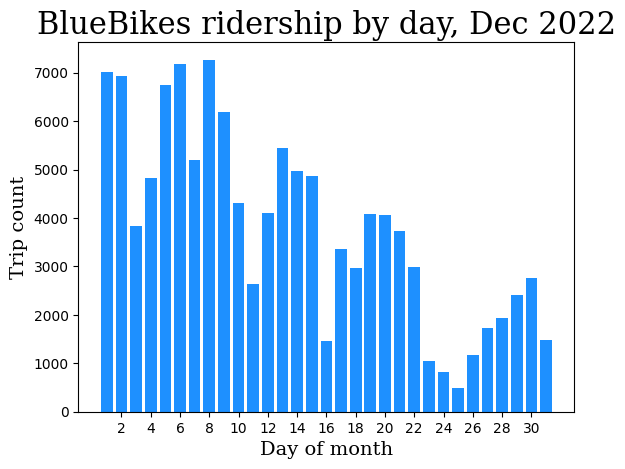

In [12]:
labels = [i.split('-')[2] for i in day_df['day']]
plt.bar(day_df['day'], day_df['count'], label = labels, color='dodgerblue')
plt.xticks(np.arange(1, 30, 2), np.arange(2, 31, 2))
plt.title('BlueBikes ridership by day, Dec 2022', family='serif', size=22)
plt.xlabel('Day of month', family='serif', size=14)
plt.ylabel('Trip count', family='serif', size=14)

Ridership steadily declined during December 2022, likely because of the declining temperature during the month.

Text(0, 0.5, 'Average ridership')

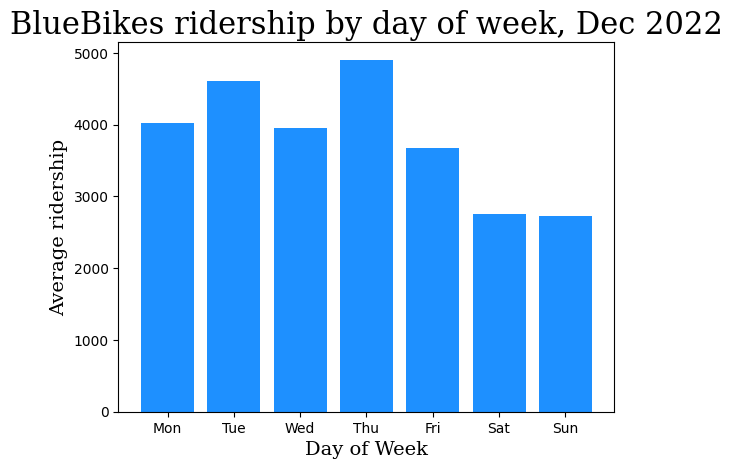

In [13]:
temp_list = np.zeros(7)
for i in np.arange(0, 7):
    count = 0
    for j in range(len(day_df)):
        if day_df['day number'][j] == i:
            temp_list[i] += day_df['count'][j]
            count += 1
    temp_list[i] /= count

plt.bar(np.arange(1,8), temp_list, color = 'dodgerblue')
plt.xticks(np.arange(1,8), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('BlueBikes ridership by day of week, Dec 2022', family='serif', size=22)
plt.xlabel('Day of Week', family='serif', size=14)
plt.ylabel('Average ridership', family='serif', size=14)

Saturday and Sunday exhibited the fewest trips per day, an expected observation given that BlueBikes are often used for commuting

## VI: Visualizing the data on a map
The maps in this section are bubble maps, with each bubble representing a BlueBikes station and the number of trips **started** there in December 2022.

### Part I: Station Usage

In [14]:
#Coordinates of the most commonly used BlueBikes stops in Dec 2022, based on starting point
coordinates = df1.groupby(['start station latitude', 'start station longitude', 'start station name'])['tripduration'].size().sort_values(ascending=False)
coordinates.head()

start station latitude  start station longitude  start station name                   
42.358100               -71.093198               MIT at Mass Ave / Amherst St             3190
42.365070               -71.103100               Central Square at Mass Ave / Essex St    2738
42.359573               -71.101295               MIT Pacific St at Purrington St          2171
42.355601               -71.103945               MIT Vassar St                            2071
42.373268               -71.118579               Harvard Square at Mass Ave/ Dunster      1767
Name: tripduration, dtype: int64

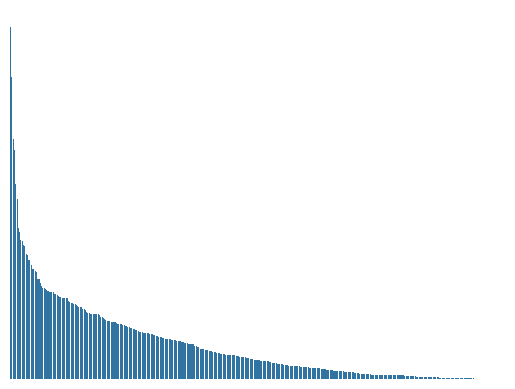

In [15]:
#A quick visualization of how the trip durations are distributed
ax1 = sns.barplot(x=np.arange(len(coordinates.to_list())), y=coordinates.to_list())
plt.axis('off')
plt.show()

In [16]:
#Creating a map to work with, using folium
map = folium.Map(location=[42.37, -71.07], tiles='cartodbdark_matter', zoom_start=13)#, width=1280, height=720)

In [17]:
#Showing which BlueBikes stations were used the most in Dec 2022 on the map
colormap = branca.colormap.LinearColormap(colors=['dodgerblue', 'red'], index=[0,np.max(coordinates.to_list())], vmax=np.max(coordinates.to_list()))
for i in range(len(coordinates)):
    folium.Circle(
        location=[coordinates.index[i][0], coordinates.index[i][1]],
        radius=coordinates.to_list()[i]/10,
        fill=True,
        fill_opacity=0.7,
        color=colormap(coordinates.to_list()[i]),
    ).add_to(map)

In [18]:
map

### Part II: Relationship with MBTA Rapid Transit stations
Looking at the above map, I noticed that three of the most used BlueBikes stations are located at or near MBTA Red Line stations (namely Harvard, Central, and Kendall/MIT). Thus, I decided to overlay the locations of MBTA Rapid Transit stations on this map and see if the proximity of a BlueBikes station to a train station affects usage levels.

In [19]:
#Reading a shp file of MBTA rapid transit stations
node_gpd = gpd.read_file(r"C:\Users\taiyo\OneDrive\Desktop\personal_projects\pp1BlueBikes\mbta_rapid_transit\MBTA_NODE.shp")
#Converting the 'geometry' column to traditional coordinates
node_gpd = node_gpd.to_crs("EPSG:4326")
#The "Silver Line" is a bus system, so we will not look at its stations
node_gpd = node_gpd[node_gpd['LINE'] != 'SILVER']
node_gpd.head()

,STATION,LINE,TERMINUS,ROUTE,geometry
0,Park Street,GREEN/RED,N,GREEN B C D E / RED A - Ashmont B - Braintree...,POINT (-71.06224 42.35631)
1,JFK/UMass,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (-71.05236 42.32064)
2,State,BLUE/ORANGE,N,BLUE Bowdoin to Wonderland / ORANGE Forest Hil...,POINT (-71.05782 42.35880)
3,Roxbury Crossing,ORANGE,N,Forest Hills to Oak Grove,POINT (-71.09573 42.33121)
42,Hynes Convention Center,GREEN,N,B C D,POINT (-71.08731 42.34798)


In [20]:
#Resetting the index
node_gpd.reset_index(inplace=True)
node_gpd.tail()

,index,STATION,LINE,TERMINUS,ROUTE,geometry
120,165,Newton Highlands,GREEN,N,D - Riverside,POINT (-71.20550 42.32235)
121,166,Eliot,GREEN,N,D - Riverside,POINT (-71.21659 42.31898)
122,167,Woodland,GREEN,N,D - Riverside,POINT (-71.24327 42.33283)
123,168,Riverside,GREEN,Y,D - Riverside,POINT (-71.25255 42.33740)
124,169,Downtown Crossing,ORANGE/RED,N,ORANGE Forest Hills to Oak Grove / RED A - Ash...,POINT (-71.06049 42.35545)


In [21]:
#Adding the MBTA stations to our map
icon_image = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/64/MBTA.svg/240px-MBTA.svg.png'
#Using custom icons for multiple locations using folium requires a workaround
#Reference: https://stackoverflow.com/questions/74200088/using-custom-icons-for-multiple-locations-with-folium-and-pandas
x = node_gpd.copy()
for i, j in x.iterrows():
    icon = folium.features.CustomIcon(icon_image, icon_size=(15,15))
    folium.Marker(
        location=[x['geometry'].y[i], x['geometry'].x[i]],
        popup=f"{node_gpd['STATION'][i]}, {node_gpd['LINE'][i]}",
        icon=icon
    ).add_to(map)

In [22]:
#Repeating the ordeal with the lines between MBTA rapid transit stations
edge_gpd = gpd.read_file(r"C:\Users\taiyo\OneDrive\Desktop\personal_projects\pp1BlueBikes\mbta_rapid_transit\MBTA_ARC.shp")
edge_gpd = edge_gpd.to_crs("EPSG:4326")
edge_gpd = edge_gpd[edge_gpd['LINE'] != 'SILVER']
edge_gpd.head()

,LINE,ROUTE,GRADE,SHAPE_LEN,geometry
0,ORANGE,Forest Hills to Oak Grove,1,1342.326419,"LINESTRING (-71.07723 42.39853, -71.07723 42.3..."
1,ORANGE,Forest Hills to Oak Grove,4,368.215569,"LINESTRING (-71.07724 42.39522, -71.07723 42.3..."
2,ORANGE,Forest Hills to Oak Grove,1,3010.706909,"LINESTRING (-71.06613 42.37155, -71.06663 42.3..."
3,GREEN,C - Cleveland Circle,2,3803.501983,"LINESTRING (-71.14929 42.33614, -71.14578 42.3..."
4,GREEN,D E,4,1621.644873,"LINESTRING (-71.06490 42.36579, -71.06541 42.3..."


In [23]:
edge_gpd['GRADE'].unique()

array([1, 4, 2, 7, 3, 6], dtype=int64)

In [24]:
#Adding the lines to the existing map
#Colors from https://cdn.mbta.com/sites/default/files/2021-03/2021-03-brand-guidelines.pdf
style_o = {'fillColor': '#ED8B00', 'color': '#ED8B00'}
style_r = {'fillColor': '#DA291C', 'color': '#DA291C'}
style_b = {'fillColor': '#003DA5', 'color': '#003DA5'}
style_g = {'fillColor': '#00843D', 'color': '#00843D'}

#Defining a function for legibility
def draw_T_line(line, style, map):
    folium.GeoJson(
        edge_gpd[edge_gpd['LINE'] == line],
        style_function = lambda x:style
    ).add_to(map)
draw_T_line('ORANGE', style_o, map)
draw_T_line('RED', style_r, map)
draw_T_line('BLUE', style_b, map)
draw_T_line('GREEN', style_g, map)

map

That turned out pretty aesthetically pleasing!

I will now create a new map with the colors of the bubbles representing distance to the nearest Rapid Transit station, as the current color coding does not add any new information.

In [25]:
#Filtering out the BlueBikes stations around Salem, using the coordinates of Lynn from https://latitude.to/map/us/united-states/cities/lynn-massachusetts
df2 = df1[(df1['start station latitude'] < 42.46676) & (df1['start station longitude'] < -70.94949)]
#Checking if I successfully filtered out 13 rows
df1['start station name'].nunique() - df2['start station name'].nunique() == 13

True

In [26]:
coordinates2 = df2.groupby(['start station latitude', 'start station longitude', 'start station name'])['tripduration'].size().sort_values(ascending=False)
coordinates2

start station latitude  start station longitude  start station name                   
42.358100               -71.093198               MIT at Mass Ave / Amherst St             3190
42.365070               -71.103100               Central Square at Mass Ave / Essex St    2738
42.359573               -71.101295               MIT Pacific St at Purrington St          2171
42.355601               -71.103945               MIT Vassar St                            2071
42.373268               -71.118579               Harvard Square at Mass Ave/ Dunster      1767
                                                                                          ... 
42.282779               -71.157289               Centre St at Parkway YMCA                   2
42.406161               -71.060417               Kearins Playground                          1
42.278812               -71.116877               American Legion Hwy at Cummins Hwy          1
42.267902               -71.093641               Mattapan 

In [27]:
#Converting coordinates2 to a pandas Dataframe
proximity = pd.DataFrame()
proximity['latitude'] = [coordinates2.index[i][0] for i in range(len(coordinates2))]
proximity['longitude'] = [coordinates2.index[i][1] for i in range(len(coordinates2))]
proximity['name'] = [coordinates2.index[i][2] for i in range(len(coordinates2))]
proximity['ridership'] = [coordinates2.to_list()[i] for i in range(len(coordinates2))]
proximity.head()

,latitude,longitude,name,ridership
0,42.358100,-71.093198,MIT at Mass Ave / Amherst St,3190
1,42.365070,-71.103100,Central Square at Mass Ave / Essex St,2738
2,42.359573,-71.101295,MIT Pacific St at Purrington St,2171
3,42.355601,-71.103945,MIT Vassar St,2071
4,42.373268,-71.118579,Harvard Square at Mass Ave/ Dunster,1767


In [28]:
#Adding columns for which train station is closest and how close it is
closest_distance_col = []
closest_name_col = []
for i in range(len(proximity)):
    closest_distance = 100
    closest_name = ""
    orig = proximity['latitude'][i], proximity['longitude'][i]
    for j in range(len(node_gpd)):
        dest = node_gpd['geometry'].y[j], node_gpd['geometry'].x[j]
        temp_distance = geodesic(orig, dest).km
        if temp_distance < closest_distance:
            closest_distance = temp_distance
            closest_name = node_gpd['STATION'][j]
    closest_distance_col.append(closest_distance)
    closest_name_col.append(closest_name)

In [29]:
proximity['distance to T'] = closest_distance_col
proximity['closest T stop'] = closest_name_col
proximity.head()

,latitude,longitude,name,ridership,distance to T,closest T stop
0,42.358100,-71.093198,MIT at Mass Ave / Amherst St,3190,0.750297,Kendall/MIT
1,42.365070,-71.103100,Central Square at Mass Ave / Essex St,2738,0.072506,Central
2,42.359573,-71.101295,MIT Pacific St at Purrington St,2171,0.684207,Central
3,42.355601,-71.103945,MIT Vassar St,2071,0.654371,Boston University East
4,42.373268,-71.118579,Harvard Square at Mass Ave/ Dunster,1767,0.088745,Harvard


In [30]:
#Creating a new map
map1 = folium.Map(location=[42.37, -71.07], zoom_start=13)

#Using folium's layer features
fg1 = folium.FeatureGroup(name='MBTA Stations', show=True)
fg2 = folium.FeatureGroup(name='BlueBikes Stations', show=True)
map1.add_child(fg1)
map1.add_child(fg2)
folium.TileLayer('openstreetmap').add_to(map1)
folium.TileLayer('cartodbdark_matter').add_to(map1)
folium.TileLayer(show=False).add_to(map1)
folium.LayerControl().add_to(map1)

#Adding BlueBikes stations
colormap = branca.colormap.StepColormap(colors=['blue','green','yellow','orange','red'], index=[0, 0.4, 0.8, 1.2, 1.6, 5])
for i in range(len(proximity)):
    location=[proximity['latitude'][i], proximity['longitude'][i]]
    folium.Circle(
        location=location,
        radius=proximity['ridership'][i]/8,
        fill=True,
        fill_opacity=0.6,
        color=colormap(proximity['distance to T'][i]),
    ).add_child(
        folium.Popup(f"'{proximity['name'][i]}';\n\n{proximity['ridership'][i]} trips;\n\n{np.round(proximity['distance to T'][i], 3)} km to {proximity['closest T stop'][i]}")
    ).add_to(fg2)

#Adding MBTA stations and lines
x = node_gpd.copy()
for i, j in x.iterrows():
    icon = folium.features.CustomIcon(icon_image, icon_size=(12,12))
    folium.Marker(
        location=[x['geometry'].y[i], x['geometry'].x[i]],
        popup=f"{node_gpd['STATION'][i]}, {node_gpd['LINE'][i]}",
        icon=icon
    ).add_to(fg1)

#Uniform colors for the MBTA lines to reduce distraction
style_hide = {'fillColor': '#888888', 'color': '#888888'}
draw_T_line('ORANGE', style_hide, fg1)
draw_T_line('RED', style_hide, fg1)
draw_T_line('BLUE', style_hide, fg1)
draw_T_line('GREEN', style_hide, fg1)
map1.save("map1.html")
map1

This map shows the distance between each BlueBikes station and its nearest MBTA Rapid Transit station, colored in 400m (approx. quarter mile) bins. 

Let us also see this data on a scatterplot:

(array([133.,  60.,  35.,  31.,  28.,  23.,  16.,  17.,   6.,   6.,   3.,
          2.,   4.,   2.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
        1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600.,
        2700., 2800., 2900., 3000., 3100., 3200., 3300., 3400., 3500.,
        3600., 3700., 3800., 3900., 4000., 4100., 4200., 4300., 4400.,
        4500., 4600., 4700., 4800., 4900.]),
 <BarContainer object of 49 artists>)

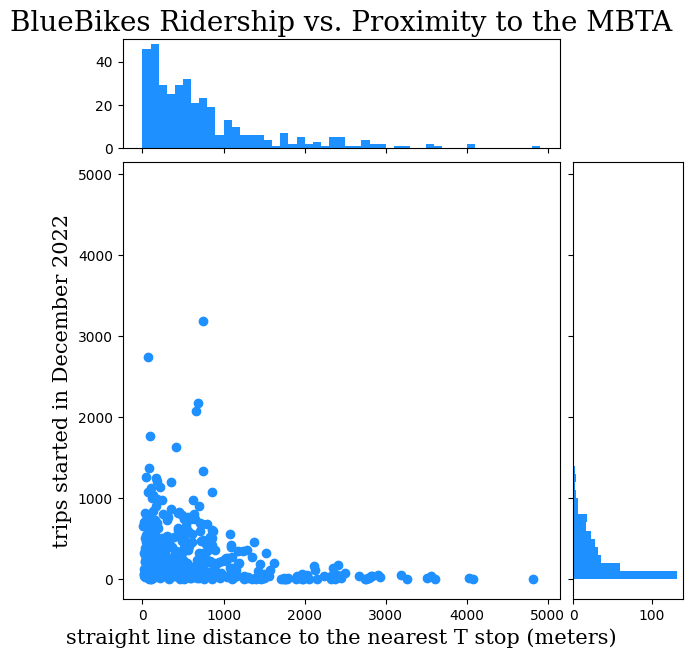

In [31]:
#Reference: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py
x = proximity['distance to T']*1000
y = proximity['ridership']

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histy = fig.add_subplot(gs[1,1], sharey=ax)

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histy.tick_params(axis='y', labelleft=False)

ax.set_xlabel('straight line distance to the nearest T stop (meters)', font='serif', fontsize=15)
ax.set_ylabel('trips started in December 2022', font='serif', fontsize=15)
ax_histx.set_title('BlueBikes Ridership vs. Proximity to the MBTA', font='serif', fontsize=20)

ax.scatter(x,y, color='dodgerblue')

width = 100
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/width) + 1) * width

bins = np.arange(0, lim + width, width)
ax_histx.hist(x, bins=bins, color='dodgerblue')
ax_histy.hist(y, bins=bins, color='dodgerblue', orientation='horizontal')

(array([ 8., 20., 28., 47., 66., 92., 97., 13.,  1.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

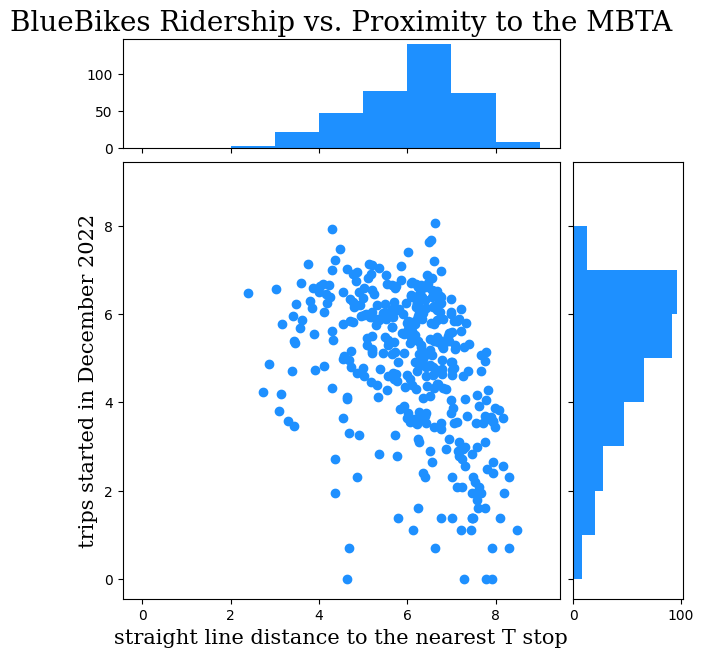

In [32]:
x = np.log(proximity['distance to T']*1000)
y = np.log(proximity['ridership'])

fig = plt.figure(figsize=(7,7))
gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histy = fig.add_subplot(gs[1,1], sharey=ax)

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histy.tick_params(axis='y', labelleft=False)

ax.set_xlabel('straight line distance to the nearest T stop', font='serif', fontsize=15)
ax.set_ylabel('trips started in December 2022', font='serif', fontsize=15)
ax_histx.set_title('BlueBikes Ridership vs. Proximity to the MBTA', font='serif', fontsize=20)

ax.scatter(x,y, color='dodgerblue')

width = 1
xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
lim = (int(xymax/width) + 1) * width

bins = np.arange(0, lim + width, width)
ax_histx.hist(x, bins=bins, color='dodgerblue')
ax_histy.hist(y, bins=bins, color='dodgerblue', orientation='horizontal')

Somewhat unfortunately, there does not seem to be a significant correlation between BlueBikes ridership and a BlueBikes station's distance to the subway.

### Part III: One problem
In this map, the distances measured are "the shortest path between 2 points on Earth". Thus, actual paths (via streets) are not accounted for. This is especially a problem for some BlueBikes stations near rivers; for example, 'Spaulding Rehabilitation Hospital - Charlestown Navy Yard' is shown as being '1.292 km to Maverick', even though there is no connection between Charlestown and East Boston.

In other words, some stations are shown as closer to a train station than they actually are.

I am currently working on using driving distance instead.

In [33]:
#Calculating driving distance takes time (my original code did not finish running even after 6 hours...), so dropping as many points as possible is crucial
#The said problem seems minimal with blue stations, and is not a problem with red stations.
droppable = (len(proximity[proximity['distance to T'] < 0.4]) + len(proximity[proximity['distance to T'] > 1.6]))
droppable, len(proximity), droppable/len(proximity)

(197, 372, 0.5295698924731183)

In [34]:
#Checking the extrema of coordinates
proximity['latitude'].min(), proximity['latitude'].max(), proximity['longitude'].min(), proximity['longitude'].max()

(42.2568376, 42.426541, -71.2477594614029, -70.99272429943085)

#### Note
The following cells are commented out because of their inefficiency. The second cell in particular takes at least 6 hours (and likely much longer) to execute.

Thus, I will leave the code here for my own future reference, and hopefully will update these cells with a quicker solution.

In [35]:
#Example of finding the driving distance between two points
"""
xmin, xmax = -71.26, -70.97
ymin, ymax = 42.24, 42.44
G = osmnx.graph_from_bbox(ymax, ymin, xmin, xmax, network_type='drive', simplify=True)
"""

In [36]:
#Using osmnx and taxicab for driving distances
#Reference: https://github.com/nathanrooy/taxicab
"""
closest_distance_col = []
closest_name_col = []
for i in range(len(proximity)):
    closest_tuple = []
    orig = proximity['latitude'][i], proximity['longitude'][i]
    for j in range(len(node_gpd)):
        dest = node_gpd['geometry'].y[j], node_gpd['geometry'].x[j]
        temp_distance = geodesic(orig, dest).km
        closest_tuple.append((orig, dest, temp_distance, node_gpd['STATION'][j]))
    closest_four_tuple = sorted(closest_tuple, key=lambda tup: tup[2])[:4]
    for k in range(len(closest_four_tuple)):
        temp_driving_distance = 1000000
        temp_driving_closest = ''
        try:
            temp = taxicab.distance.shortest_path(G, closest_four_tuple[k][0], closest_four_tuple[k][1])[0]
        finally:
            continue
        if temp < temp_driving_distance:
            temp_driving_distance = temp
            temp_driving_closest = closest_four_tuple[k][3]
    closest_distance_col.append(temp_driving_distance)
    closest_name_col.append(temp_driving_closest)
"""

"\nclosest_distance_col = []\nclosest_name_col = []\nfor i in range(len(proximity)):\n    closest_tuple = []\n    orig = proximity['latitude'][i], proximity['longitude'][i]\n    for j in range(len(node_gpd)):\n        dest = node_gpd['geometry'].y[j], node_gpd['geometry'].x[j]\n        temp_distance = geodesic(orig, dest).km\n        closest_tuple.append((orig, dest, temp_distance, node_gpd['STATION'][j]))\n    closest_four_tuple = sorted(closest_tuple, key=lambda tup: tup[2])[:4]\n    for k in range(len(closest_four_tuple)):\n        temp_driving_distance = 1000000\n        temp_driving_closest = ''\n        try:\n            temp = taxicab.distance.shortest_path(G, closest_four_tuple[k][0], closest_four_tuple[k][1])[0]\n        finally:\n            continue\n        if temp < temp_driving_distance:\n            temp_driving_distance = temp\n            temp_driving_closest = closest_four_tuple[k][3]\n    closest_distance_col.append(temp_driving_distance)\n    closest_name_col.append

In [37]:
"""
proximity['distance to T'] = closest_distance_col
proximity['closest T stop'] = closest_name_col
proximity.head()
"""

"\nproximity['distance to T'] = closest_distance_col\nproximity['closest T stop'] = closest_name_col\nproximity.head()\n"

### Part IV: Where do people go to MIT from?

Originally, I thought of making a map with lines representing every BlueBikes trip made in December 2022. However, I realized that there were too many unique trips to make such a map bearable to look at.

So, here I focus on one station and where its bicycles end up.

In [38]:
mit_test_df = df1[df1['start station name'] == 'MIT at Mass Ave / Amherst St']
mit_test_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
39,4.916667,2022-12-01 00:45:07.5110,2022-12-01 00:50:03.4070,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,184,Sidney Research Campus/Erie Street at Waverly,42.357753,-71.103934,2764,Subscriber,02139
40,10.783333,2022-12-01 00:46:20.3840,2022-12-01 00:57:07.8030,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,226,Commonwealth Ave At Babcock St,42.351547,-71.121262,4258,Subscriber,02139
43,7.750000,2022-12-01 00:50:01.6070,2022-12-01 00:57:47.3450,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,544,Old Morse Park at Putnam Ave,42.357662,-71.108413,4368,Subscriber,02139
53,3.600000,2022-12-01 01:04:46.3340,2022-12-01 01:08:23.0690,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,177,University Park,42.362648,-71.100061,2122,Subscriber,02139
61,2.516667,2022-12-01 01:10:05.9340,2022-12-01 01:12:37.0930,67,MIT at Mass Ave / Amherst St,42.3581,-71.093198,380,Mass Ave at Albany St,42.361358,-71.096703,2875,Subscriber,02139


In [39]:
mit_grouped = mit_test_df.groupby(['end station latitude', 'end station longitude'])['tripduration'].size().sort_values(ascending=False)
mit_grouped

end station latitude  end station longitude
42.365070             -71.103100               272
42.355601             -71.103945               254
42.349244             -71.097282               235
42.360859             -71.085519               122
42.360542             -71.086698               108
                                              ... 
42.346551             -71.128332                 1
42.380857             -71.070629                 1
42.333293             -71.101246                 1
42.382678             -71.143479                 1
42.407435             -71.055332                 1
Name: tripduration, Length: 182, dtype: int64

In [40]:
map = folium.Map(location=[42.3581, -71.093198], tiles='cartodbdark_matter', zoom_start=12)#, width=1280, height=720)

In [41]:
colormap = branca.colormap.LinearColormap(colors=['dodgerblue', 'red'], index=[0,np.max(mit_grouped.to_list())], vmax=np.max(mit_grouped.to_list()))
for i in range(len(mit_grouped)):
    folium.Circle(
        location=[mit_grouped.index[i][0], mit_grouped.index[i][1]],
        radius=mit_grouped.to_list()[i],
        fill=True,
        fill_opacity=0.7,
        color=colormap(mit_grouped.to_list()[i]),
    ).add_to(map)
"""
folium.Marker(
    location=[42.3581, -71.093198],
    popup='MIT at Mass Ave / Amherst St',
    icon=folium.Icon(icon='1', prefix='fa', color='red')
).add_to(map)
"""

"\nfolium.Marker(\n    location=[42.3581, -71.093198],\n    popup='MIT at Mass Ave / Amherst St',\n    icon=folium.Icon(icon='1', prefix='fa', color='red')\n).add_to(map)\n"

In [42]:
for i in range(len(mit_grouped)):
    folium.PolyLine(locations=[[42.3581, -71.093198],mit_grouped.index[i]], color='white', weight=mit_grouped.to_list()[i]/50).add_to(map)

In [43]:
map